In [1]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, ElasticNet

# Load the dataset
Ames = pd.read_csv('~/Documents/NYCDSA/Third Project/ML_Ames_Housing/data/Ames_Housing_Price_Data.csv', index_col=0)
Ames = Ames.drop(columns=['PID'])
# Convert the below numeric features to categorical features
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')
Ames['YearRemodAdd'] = Ames['YearRemodAdd'].astype('object')
Ames['GarageYrBlt'] = Ames['GarageYrBlt'].astype('str')
Ames['YearBuilt'] = Ames['YearBuilt'].astype('object')
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')

# Exclude 'PID' and 'SalePrice' from features and specifically handle the 'Electrical' column
numeric_features = Ames.select_dtypes(include=['int64', 'float64']).drop(columns=['SalePrice','BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1','1stFlrSF', '2ndFlrSF', 'LowQualFinSF']).columns
categorical_features = Ames.select_dtypes(include=['object']).columns.difference(['Electrical'])
electrical_feature = ['Electrical']

In [2]:
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']
}


# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for 'Electrical': Fill missing value with mode then apply ordinal encoding
electrical_transformer = Pipeline(steps=[
    ('impute_electrical', SimpleImputer(strategy='most_frequent')),
    ('ordinal_electrical', OrdinalEncoder(categories=[ordinal_order['Electrical']]))
])

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [3]:
# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combined preprocessor for numeric, ordinal, nominal, and specific electrical data
preprocessor = ColumnTransformer(
    transformers=[
        ('electrical', electrical_transformer, ['Electrical']),
        ('num', numeric_transformer, numeric_features),
        ('nominal', categorical_transformer, categorical_features)
])


# Apply the preprocessing pipeline to Ames
transformed_data = preprocessor.fit_transform(Ames)

# Generate column names for the one-hot encoded features
onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()

In [4]:
# Combine all feature names
all_feature_names = ['Electrical'] + list(numeric_features) + list(onehot_features)

 # Convert the transformed array to a DataFrame
transformed_df = pd.DataFrame(transformed_data.toarray(), columns=all_feature_names)
transformed_df

,Electrical,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,...,x46_2006,x46_2007,x46_2008,x46_2009,x46_2010,x47_2006,x47_2007,x47_2008,x47_2009,x47_2010
0,4.0,-1.289598,6.869938e-16,-0.274468,-0.033733,0.339988,-0.566310,-0.431859,1.089201,-0.253973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4.0,-0.894555,-1.281863e+00,-0.724294,-0.765088,-0.551444,0.283369,0.029430,1.089201,-0.253973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.0,-0.992804,-4.116906e-01,-0.499689,-0.765088,3.014285,-0.566310,-0.477270,-0.839343,-0.253973,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.0,-0.915024,5.551672e-01,-0.242962,-1.496443,2.122852,-0.566310,-1.509792,-0.839343,-0.253973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.0,0.366305,7.173829e-02,-0.211702,1.428977,0.339988,-0.566310,-0.541803,1.089201,-0.253973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2.0,-1.093100,6.869938e-16,-0.155827,-0.033733,0.339988,-0.566310,-0.202409,-0.839343,-0.253973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2576,3.0,0.505490,6.869938e-16,0.438115,-2.227798,-0.551444,-0.566310,-2.477781,-0.839343,-0.253973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2577,3.0,1.056093,6.518530e-01,-0.473844,-0.765088,0.339988,-0.566310,-0.085295,-0.839343,-0.253973,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2578,4.0,0.728597,6.869938e-16,-0.159273,0.697622,-0.551444,0.254857,-0.123536,1.089201,-0.253973,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
models = {
    'Lasso': Lasso(max_iter=20000),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(max_iter=20000)
}

lasso_model = Lasso(max_iter=20000)
pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lasso_model)
])

ridge_model = Ridge()
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ridge_model)
])

elastic_model = ElasticNet(max_iter=20000)
pipeline3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', elastic_model)
])

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
lasso_default_scores = cross_val_score(pipeline1, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
ridge_default_scores = cross_val_score(pipeline2, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
elastic_default_scores = cross_val_score(pipeline3, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)

In [7]:
print(lasso_default_scores)
print(ridge_default_scores)
print(elastic_default_scores)

[0.89170273 0.89268492 0.92149465 0.77104096 0.91619835 0.88923591
 0.91994559 0.90723056 0.88052894 0.8538089 ]
[0.90049859 0.91023453 0.92362048 0.78521892 0.92212731 0.90945072
 0.92411898 0.91624524 0.89350354 0.88258125]
[0.83858886 0.86141541 0.86480249 0.83488425 0.87371117 0.86148292
 0.86262097 0.88830459 0.85833005 0.86123495]


In [8]:
print(np.mean(lasso_default_scores))
print(np.mean(ridge_default_scores))
print(np.mean(elastic_default_scores))

0.8843871509666063
0.89675995610806
0.8605375666782363


In [9]:
lasso_data = [['F1', 0.89174297, 0.8917], 
        ['F2', 0.8926416, 0.8926], 
        ['F3', 0.92153297, 0.9215], 
        ['F4', 0.77096504, 0.7709], 
        ['F5', 0.91613192, 0.9161],
        ['F6', 0.88928344, 0.8892], 
        ['F7', 0.9199287, 0.9199], 
        ['F8', 0.90724628, 0.9072], 
        ['F9', 0.88034432, 0.8803], 
        ['F10', 0.85361757, 0.8536]]

ridge_data = [['F1', 0.90052174, 0.9005], 
        ['F2', 0.91025265, 0.9103], 
        ['F3', 0.92369907, 0.9237], 
        ['F4', 0.7851992, 0.7852], 
        ['F5', 0.92213374, 0.9221],
        ['F6', 0.90945303, 0.9095], 
        ['F7', 0.92406629, 0.9241], 
        ['F8', 0.91623126, 0.9162], 
        ['F9', 0.89339493, 0.8934], 
        ['F10', 0.88244913, 0.8824]]

elastic_data = [['F1', 0.83861297, 0.8386], 
        ['F2', 0.86140948, 0.8614], 
        ['F3', 0.86480591, 0.8648], 
        ['F4', 0.83489009, 0.8349], 
        ['F5', 0.87370379, 0.8737],
        ['F6', 0.86149478, 0.8615], 
        ['F7', 0.86261396, 0.8626], 
        ['F8', 0.88827465, 0.8883], 
        ['F9', 0.85841703, 0.8584], 
        ['F10', 0.86123529, 0.8612]]

# lasso_data = [['F1', 0.89534782, 0.8953], 
#         ['F2', 0.85634415, 0.8563], 
#         ['F3', 0.90067293, 0.9006], 
#         ['F4', 0.90802961, 0.9080], 
#         ['F5', 0.86539836, 0.8653]]
              
lasso_df = pd.DataFrame(lasso_data, columns=['Fold', 'Score', 'mark_value'])

ridge_df = pd.DataFrame(ridge_data, columns=['Fold', 'Score', 'mark_value'])

elastic_df = pd.DataFrame(elastic_data, columns=['Fold', 'Score', 'mark_value'])

elastic_df

,Fold,Score,mark_value
0,F1,0.838613,0.8386
1,F2,0.861409,0.8614
2,F3,0.864806,0.8648
3,F4,0.834890,0.8349
4,F5,0.873704,0.8737
5,F6,0.861495,0.8615
6,F7,0.862614,0.8626
7,F8,0.888275,0.8883
8,F9,0.858417,0.8584
9,F10,0.861235,0.8612


C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


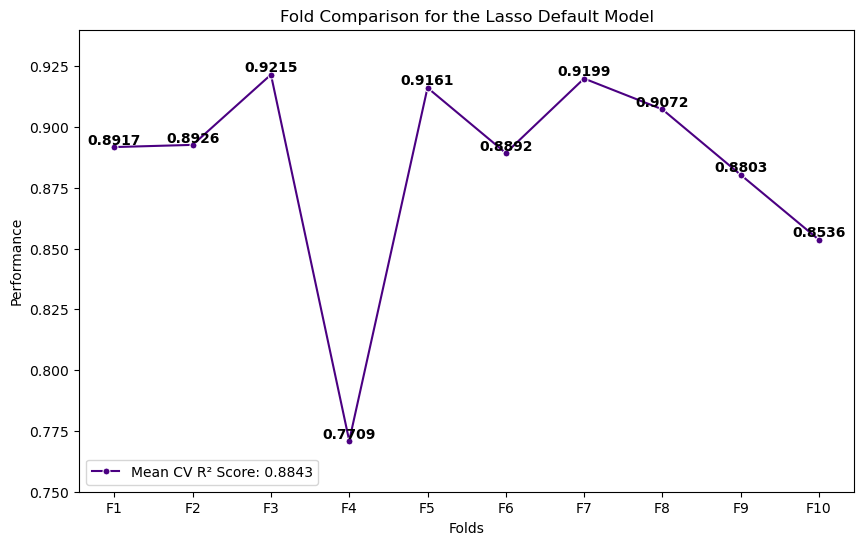

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.ylim(.75, .94)
sns.lineplot(data=lasso_df, x="Fold", y="Score", color='#4B0082', marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the Lasso Default Model')
plt.legend(markerscale=10)


palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,lasso_df.shape[0]):
     plt.text(lasso_df.Fold[line], lasso_df.mark_value[line], lasso_df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Mean CV R² Score: 0.8843'], loc='lower left')
plt.show()

C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


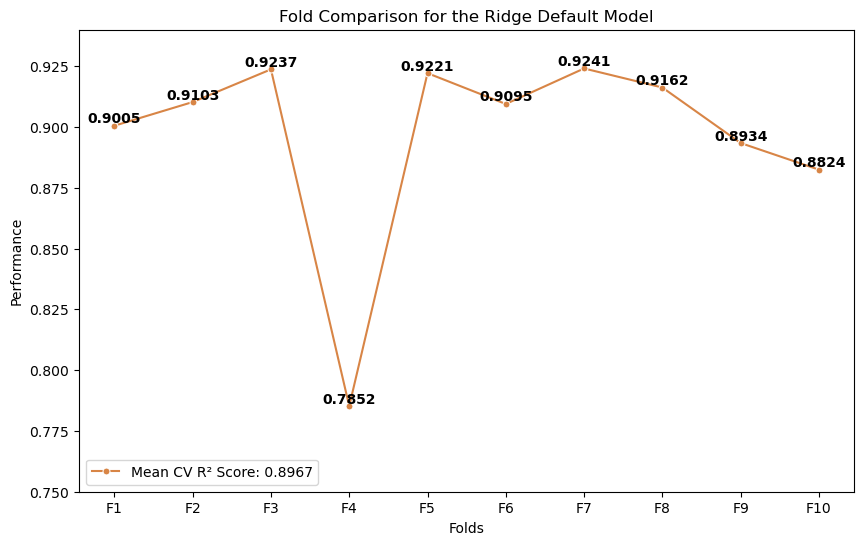

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=ridge_df, x="Fold", y="Score", color='#d88546', marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the Ridge Default Model')
plt.legend(markerscale=10)
plt.ylim(.75, .94)

palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,ridge_df.shape[0]):
     plt.text(ridge_df.Fold[line], ridge_df.mark_value[line], ridge_df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Mean CV R² Score: 0.8967'], loc='lower left')
plt.show()

C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


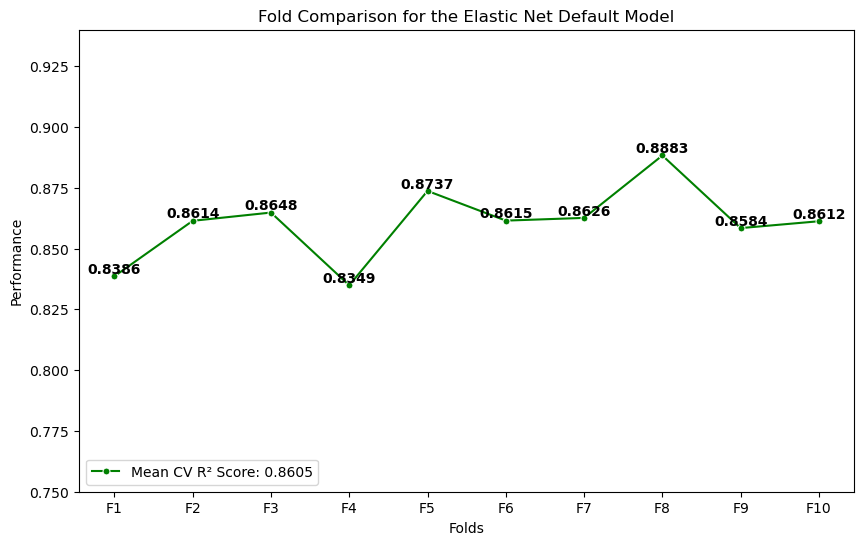

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=elastic_df, x="Fold", y="Score", color='#008000', marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the Elastic Net Default Model')
plt.legend(markerscale=10)
plt.ylim(.75, .94)

palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,elastic_df.shape[0]):
     plt.text(elastic_df.Fold[line], elastic_df.mark_value[line], elastic_df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Mean CV R² Score: 0.8605'], loc='lower left')
plt.show()

In [19]:
pd.set_option('display.max_rows', 500)
scores = []
coefficients_list = []
fold_num = 1
for train_index, test_index in kf.split(Ames):
    X_train, X_test = Ames.drop(columns='SalePrice').iloc[train_index], Ames.drop(columns='SalePrice').iloc[test_index]
    y_train, y_test = Ames['SalePrice'].iloc[train_index], Ames['SalePrice'].iloc[test_index]
    results = pipeline1.fit(X_train, y_train)
    scores.append(pipeline1.score(X_test, y_test))
average_score = np.mean(scores)
print(f"Mean CV R² Score of Combined Model: {average_score:.4f}")

Mean CV R² Score of Combined Model: 0.8844


In [20]:
param_grids = {
    'Lasso': {'regressor__alpha': [40, 50, 60]},
    'Ridge': {'regressor__alpha': [40, 50, 60]},
    'ElasticNet': {'regressor__alpha': [0.01, 0.1, 1, 10], 'regressor__l1_ratio': [0.8, .9, .95]}
}
# Target variable
y = Ames['SalePrice']
# All features
X = Ames.drop(columns='SalePrice')

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    # Set up the GridSearchCV to find the best parameters
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[name], cv=kf, n_jobs=-1)
    grid_search.fit(X, y)
    best_score = round(grid_search.best_score_, 4)
    best_params = grid_search.best_params_
    results[name] = {'Best Score': best_score, 'Best Params': best_params}
# Output the grid search results
print("Grid Search Results:", results) #if the result is leaning towards the end, that usually means it leans towards lasso, unless it's leaning towards .01

Grid Search Results: {'Lasso': {'Best Score': 0.9022, 'Best Params': {'regressor__alpha': 40}}, 'Ridge': {'Best Score': 0.9023, 'Best Params': {'regressor__alpha': 40}}, 'ElasticNet': {'Best Score': 0.903, 'Best Params': {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}}}


In [21]:
param_grids = {'regressor__alpha': [40]
}

param_grids_elastic = {'regressor__alpha': [0.01, 0.1, 1, 10], 'regressor__l1_ratio': [0.8, .9, .95]
}

grid_search_lasso = GridSearchCV(pipeline1, param_grid=param_grids, cv=kf, n_jobs=-1)
grid_search_lasso.fit(X, y)


grid_search_ridge = GridSearchCV(pipeline2, param_grid=param_grids, cv=kf, n_jobs=-1)
grid_search_ridge.fit(X, y)


grid_search_elastic = GridSearchCV(pipeline3, param_grid=param_grids_elastic, cv=kf, n_jobs=-1)
grid_search_elastic.fit(X, y)

lasso_predictions101 = grid_search_lasso.best_estimator_.predict(Ames.drop(columns='SalePrice'))
ridge_predictions101 = grid_search_ridge.best_estimator_.predict(Ames.drop(columns='SalePrice'))
elastic_predictions101 = grid_search_ridge.best_estimator_.predict(Ames.drop(columns='SalePrice'))

In [22]:
cross_val_score_gb = cross_val_score(grid_search_lasso, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
print(cross_val_score_gb)
print('Avg Score:',np.mean(cross_val_score_gb))

[0.90537781 0.91043809 0.92676566 0.80422333 0.9261547  0.91492978
 0.92533608 0.92271338 0.90214351 0.88355604]
Avg Score: 0.9021638380242305


In [23]:
cross_val_score_gb = cross_val_score(grid_search_ridge, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
print(cross_val_score_gb)
print('Avg Score:',np.mean(cross_val_score_gb))

[0.90080569 0.91691824 0.9190046  0.80205487 0.92265907 0.91159128
 0.91886364 0.92177112 0.90121743 0.90818324]
Avg Score: 0.9023069190403856


In [24]:
cross_val_score_gb = cross_val_score(grid_search_elastic, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
print(cross_val_score_gb)
print('Avg Score:',np.mean(cross_val_score_gb))

[0.9026992  0.91699672 0.92010793 0.79952266 0.92412956 0.91309035
 0.92134522 0.92221439 0.9008597  0.90703515]
Avg Score: 0.9028000865276964


In [25]:
lasso_data = [['F1', 0.90537786, 0.9054], 
        ['F2', 0.91046619, 0.9105], 
        ['F3', 0.92678537, 0.9268], 
        ['F4', 0.80422672, 0.8042], 
        ['F5', 0.9261622, 0.9262],
        ['F6', 0.91492418, 0.9149], 
        ['F7', 0.92529224, 0.9253], 
        ['F8', 0.92270779, 0.9227], 
        ['F9', 0.90214356, 0.9021], 
        ['F10', 0.88355019, 0.8836]]

ridge_data = [['F1', 0.90078921, 0.9008], 
        ['F2', 0.91698422, 0.9169], 
        ['F3', 0.91901364, 0.9190], 
        ['F4', 0.80202104, 0.8020], 
        ['F5', 0.92271731, 0.9227],
        ['F6', 0.91159812, 0.9116], 
        ['F7', 0.9187542, 0.9188], 
        ['F8', 0.92170551, 0.9217], 
        ['F9', 0.90122685, 0.9012], 
        ['F10', 0.90814671, 0.9081]]

elastic_data = [['F1', 0.90267318, 0.9027], 
        ['F2', 0.9170576, 0.9171], 
        ['F3', 0.92012657, 0.9201], 
        ['F4', 0.79948857, 0.7995], 
        ['F5', 0.92418122, 0.9242],
        ['F6', 0.91309546, 0.9131], 
        ['F7', 0.92122581, 0.9212], 
        ['F8', 0.92213076, 0.9221], 
        ['F9', 0.90087988, 0.9009], 
        ['F10', 0.90698855, 0.9069]]
              
lasso_df = pd.DataFrame(lasso_data, columns=['Fold', 'Score', 'mark_value'])

ridge_df = pd.DataFrame(ridge_data, columns=['Fold', 'Score', 'mark_value'])

elastic_df = pd.DataFrame(elastic_data, columns=['Fold', 'Score', 'mark_value'])

elastic_df

,Fold,Score,mark_value
0,F1,0.902673,0.9027
1,F2,0.917058,0.9171
2,F3,0.920127,0.9201
3,F4,0.799489,0.7995
4,F5,0.924181,0.9242
5,F6,0.913095,0.9131
6,F7,0.921226,0.9212
7,F8,0.922131,0.9221
8,F9,0.900880,0.9009
9,F10,0.906989,0.9069


C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


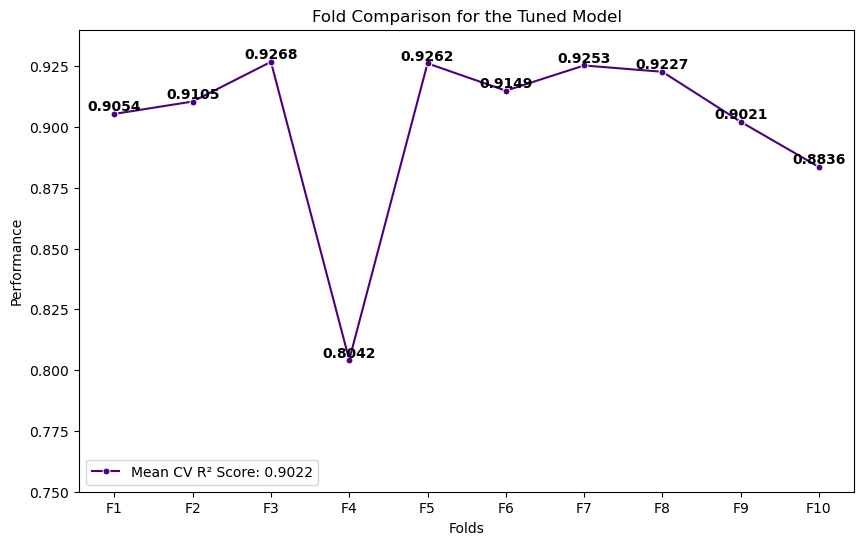

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=lasso_df, x="Fold", y="Score", color='#4B0082', marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the Tuned Model')
plt.legend(markerscale=10)
plt.ylim(.75, .94)

palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,lasso_df.shape[0]):
     plt.text(lasso_df.Fold[line], lasso_df.mark_value[line], lasso_df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Mean CV R² Score: 0.9022'], loc='lower left')
plt.show()

C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


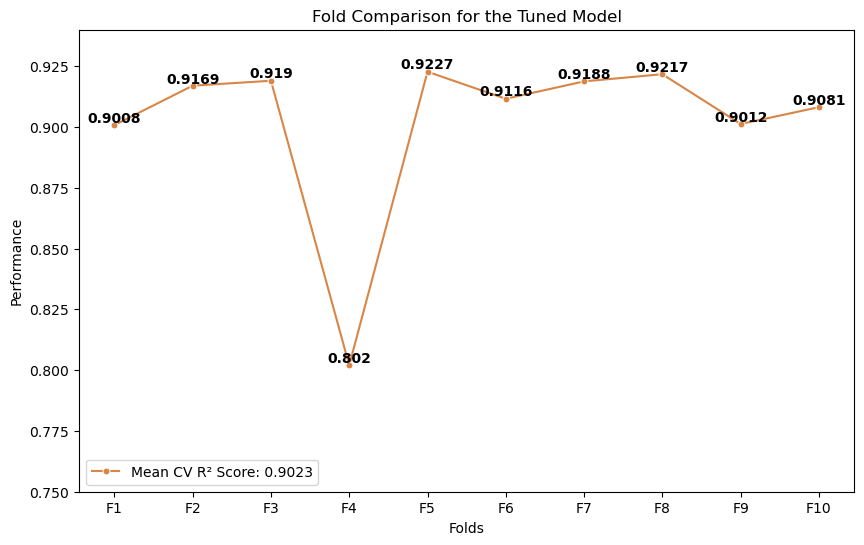

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=ridge_df, x="Fold", y="Score", color='#d88546', marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the Tuned Model')
plt.legend(markerscale=10)
plt.ylim(.75, .94)

palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,ridge_df.shape[0]):
     plt.text(ridge_df.Fold[line], ridge_df.mark_value[line], ridge_df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Mean CV R² Score: 0.9023'], loc='lower left')
plt.show()

C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


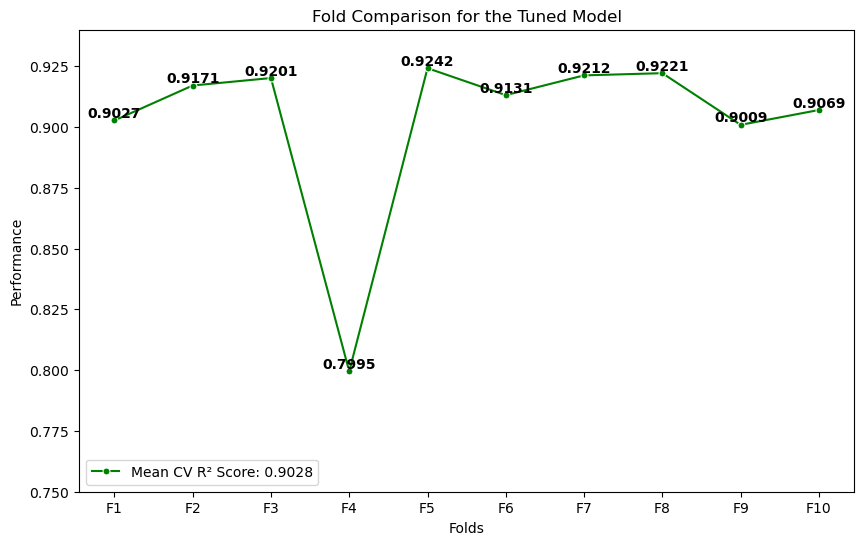

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=elastic_df, x="Fold", y="Score", color='#008000', marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the Tuned Model')
plt.legend(markerscale=10)
plt.ylim(.75, .94)

palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,elastic_df.shape[0]):
     plt.text(elastic_df.Fold[line], elastic_df.mark_value[line], elastic_df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Mean CV R² Score: 0.9028'], loc='lower left')
plt.show()

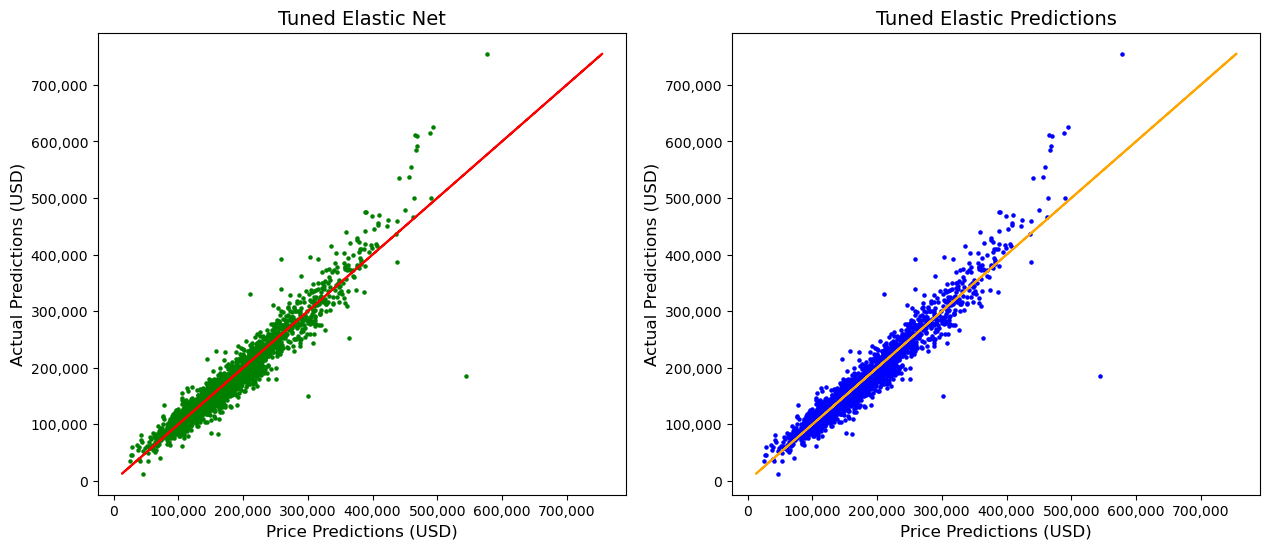

In [35]:
import matplotlib as matplotlib
target = Ames['SalePrice']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(elastic_predictions101, target, s = 5, c = '#008000')
ax1.plot(target, target, c = 'red')
ax1.set_xlabel('Price Predictions (USD)', fontsize = 12)
ax1.set_ylabel('Actual Predictions (USD)', fontsize = 12)
ax1.set_title('Tuned Elastic Net', fontsize = 14)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.scatter(elastic_predictions101, target, s = 5, c = 'blue')
ax2.plot(target, target, c = 'orange')
ax2.set_xlabel('Price Predictions (USD)', fontsize = 12)
ax2.set_ylabel('Actual Predictions (USD)', fontsize = 12)
ax2.set_title('Tuned Elastic Predictions', fontsize = 14)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [8]:
# fold_scores = []
# fold_num = 1
# for train_index, test_index in kf.split(Ames):
#     X_train, X_test = Ames.drop(columns='SalePrice').iloc[train_index], Ames.drop(columns='SalePrice').iloc[test_index]
#     y_train, y_test = Ames['SalePrice'].iloc[train_index], Ames['SalePrice'].iloc[test_index]
#     grid_search_lasso.fit(X_train, y_train)
#     fold_score = cross_val_score(random_forest_pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
#     print(f'Score for Fold: {fold_num}', fold_score)
#     fold_scores.append({
#         'score':fold_score,
#         'fold':fold_num})
#     fold_num += 1

cross_val_score(grid_search_lasso, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)

array([0.9082804 , 0.8757711 , 0.9202146 , 0.92104561, 0.89295877])

In [9]:
# fold_scores = []
# fold_num = 1
# for train_index, test_index in kf.split(Ames):
#     X_train, X_test = Ames.drop(columns='SalePrice').iloc[train_index], Ames.drop(columns='SalePrice').iloc[test_index]
#     y_train, y_test = Ames['SalePrice'].iloc[train_index], Ames['SalePrice'].iloc[test_index]
#     grid_search_ridge.fit(X_train, y_train)
#     fold_score = grid_search_ridge.score(X_test, y_test)
#     print(f'Score for Fold: {fold_num}', fold_score)
#     fold_scores.append({
#         'score':fold_score,
#         'fold':fold_num})
#     fold_num += 1

cross_val_score(grid_search_ridge, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)

array([0.90831601, 0.87123446, 0.91519447, 0.91820398, 0.90515607])

In [10]:
# fold_scores = []
# fold_num = 1
# for train_index, test_index in kf.split(Ames):
#     X_train, X_test = Ames.drop(columns='SalePrice').iloc[train_index], Ames.drop(columns='SalePrice').iloc[test_index]
#     y_train, y_test = Ames['SalePrice'].iloc[train_index], Ames['SalePrice'].iloc[test_index]
#     grid_search_elastic.fit(X_train, y_train)
#     fold_score = grid_search_elastic.score(X_test, y_test)
#     print(f'Score for Fold: {fold_num}', fold_score)
#     fold_scores.append({
#         'score':fold_score,
#         'fold':fold_num})
#     fold_num += 1

cross_val_score(grid_search_elastic, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)

array([0.91005623, 0.87056515, 0.91505236, 0.91811283, 0.90516361])

In [36]:
data_default = {
    'model':['Lasso','Ridge','Elastic'],
    'f1':[0.89174297, 0.90052174, 0.83861297],
    'f2':[0.8926416, 0.91025265, 0.86140948],
    'f3':[0.92153297, 0.92369907, 0.86480591],
    'f4':[0.77096504, 0.7851992, 0.83489009],
    'f5':[0.91613192, 0.92213374, 0.87370379],
    'f6':[0.88928344, 0.90945303, 0.86149478],
    'f7':[0.9199287, 0.92406629, 0.86261396],
    'f8':[0.90724628, 0.91623126, 0.88827465],
    'f9':[0.88034432, 0.89339493, 0.85841703],
    'f10':[0.85361757, 0.88244913, 0.86123529],
}

model_stats_default = pd.DataFrame(data_default)
model_stats_default = model_stats_default.set_index('model').T
model_stats_default

model,Lasso,Ridge,Elastic
f1,0.891743,0.900522,0.838613
f2,0.892642,0.910253,0.861409
f3,0.921533,0.923699,0.864806
f4,0.770965,0.785199,0.834890
f5,0.916132,0.922134,0.873704
f6,0.889283,0.909453,0.861495
f7,0.919929,0.924066,0.862614
f8,0.907246,0.916231,0.888275
f9,0.880344,0.893395,0.858417
f10,0.853618,0.882449,0.861235


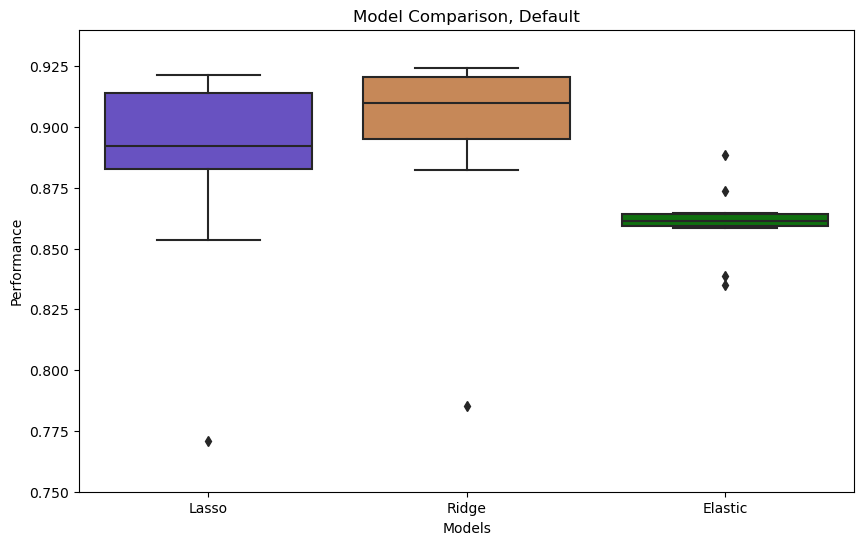

In [37]:
import seaborn as sns
palette = ['#5D3FD3', '#d88546', '#008000']
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=model_stats_default, palette=palette)
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Model Comparison, Default')
plt.ylim(.75, .94)
plt.show()

In [38]:
data_tuned = {
    'model':['Lasso','Ridge','Elastic'],
    'f1':[0.90537786, 0.90078921, 0.90267318],
    'f2':[0.91046619, 0.91698422, 0.9170576],
    'f3':[0.92678537, 0.91901364, 0.92012657],
    'f4':[0.80422672, 0.80202104, 0.79948857],
    'f5':[0.9261622, 0.92271731, 0.92418122],
    'f6':[0.91492418, 0.91159812, 0.91309546],
    'f7':[0.92529224, 0.9187542, 0.92122581],
    'f8':[0.92270779, 0.92170551, 0.92213076],
    'f9':[0.90214356, 0.90122685, 0.90087988],
    'f10':[0.88355019, 0.90814671, 0.90698855],
}

model_stats_tuned = pd.DataFrame(data_tuned)
model_stats_tuned = model_stats_tuned.set_index('model').T
model_stats_tuned

model,Lasso,Ridge,Elastic
f1,0.905378,0.900789,0.902673
f2,0.910466,0.916984,0.917058
f3,0.926785,0.919014,0.920127
f4,0.804227,0.802021,0.799489
f5,0.926162,0.922717,0.924181
f6,0.914924,0.911598,0.913095
f7,0.925292,0.918754,0.921226
f8,0.922708,0.921706,0.922131
f9,0.902144,0.901227,0.900880
f10,0.883550,0.908147,0.906989


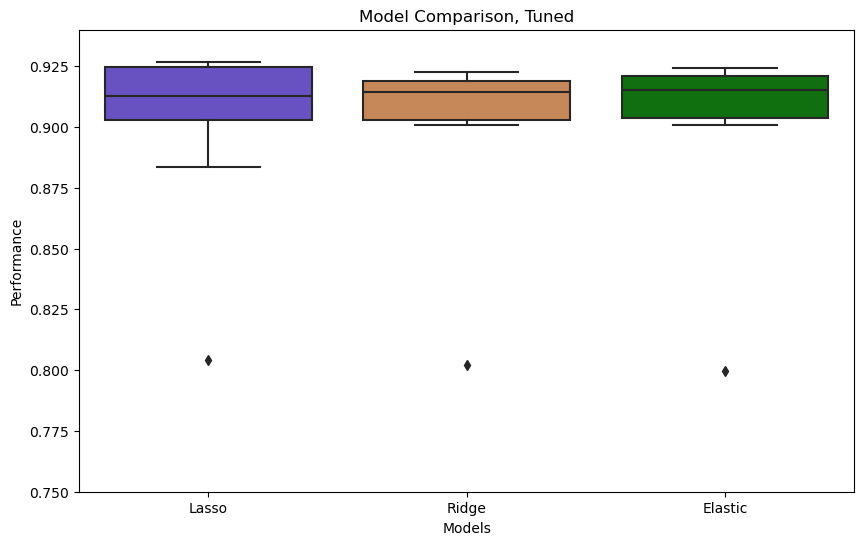

In [39]:
import seaborn as sns
palette = ['#5D3FD3', '#d88546', '#008000']
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=model_stats_tuned, palette=palette)
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Model Comparison, Tuned')
plt.ylim(.75, .94)
plt.show()